In [22]:
import pickle
import datetime

import numpy as np
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia


In [2]:
plt.rcParams.update({"font.size": 15})

In [4]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.Q, J_ground=1, F1=1 / 2, F=0
    ),
]

polarizations = [
    [couplings.polarization_σm, couplings.polarization_σp, couplings.polarization_Z],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)


In [5]:
# ignore small decay to J=4
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    decay_channels=None,
    Jmax_X=3,
)


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [7]:
odepars = lindblad_julia.odeParameters(
    Ω0=1 * hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    T="2*3.141592653589793/ω0",
    P0="t%T",
    Pσm0="(P0>0) & (P0 <=T/3)",
    Pσp0="(P0> T/3) & (P0 <=2*T/3)",
    PZ0="(P0>2*T/3) & (P0 <= T)",
    ω0=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
)


In [8]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=6
        )
    except Exception as e:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        logging.error(e)
        if counter > 3:
            raise e
        continue
    break


ERROR:root:Exception 'InitError: could not load library "libamd.dll"
The specified module could not be found. 
during initialization of module SuiteSparse_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    
ERROR:root:Exception 'InitError: could not load library "C:\Users\ogras\.julia\artifacts\89e2de680927805ce1a0b46b9ca742383fa224e7\bin\libsundials_sunlinsolklu.dll"
The specified module could not be found. 
during initialization of module Sundials_jll' occurred while calling julia code:

        @everywhere begin
            using LinearAlgebra
            using Trapz
            using DifferentialEquations
        end
    


In [9]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")


,"|B, J = 1, F₁ = 1/2, F = 0>"
states,
"|X, J = 1>",1.0


In [10]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)


,"|B, J = 1, F₁ = 1/2, F = 0>"
states,
"|X, J = 1, F₁ = 1/2, F = 1>",0.747254
"|X, J = 1, F₁ = 3/2, F = 1>",0.252746


In [11]:
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)


In [12]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.X),
    obe_system.QN,
)


In [14]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

# stop simulation when the molecules reach the end of the multipass

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 200e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6, reltol=1e-3, abstol=1e-7, save_everystep=True, callback=None
)


In [15]:
results = lindblad_julia.do_simulation_single(problem, config=config)


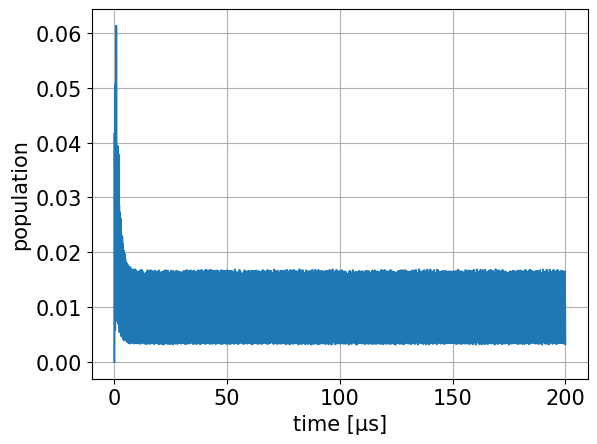

In [16]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()


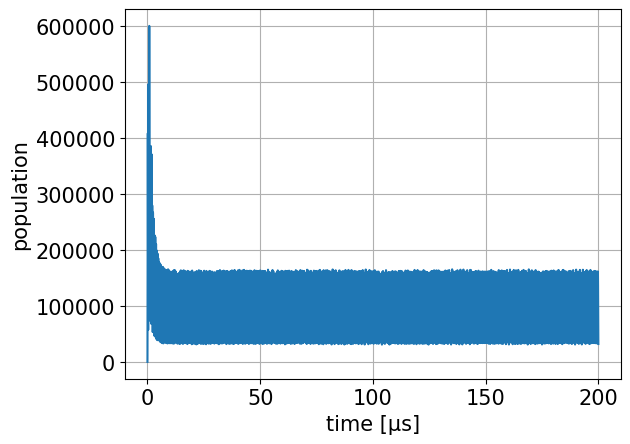

In [20]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T * hamiltonian.Γ)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()


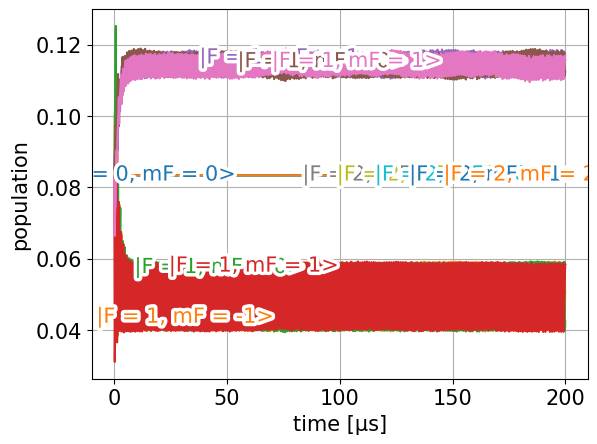

In [17]:
labels = [
    obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in indices_J1
]

fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_J1].T, label=labels)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

labelLines(ax.get_lines(), zorder=2.5, align=False)

ax.grid()


In [25]:
trapezoid(results.y[indices_excited].flatten() * hamiltonian.Γ, results.t)

np.float64(20.150231548183136)